In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import normalize
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Add, LSTM, Activation, Flatten, Dropout, SimpleRNN, Bidirectional, Conv1D, GRU, Input, BatchNormalization
from keras.models import Model
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
py.init_notebook_mode(connected=True)
from googlefinance.client import get_price_data, get_prices_data, get_prices_time_data
import fix_yahoo_finance as yf
from stockstats import StockDataFrame
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.utils import shuffle
%matplotlib inline

Using TensorFlow backend.


In [2]:
Stock="CCE"
def data_prepare(Stock):
    df=pd.read_csv(Stock+'.csv')
    data=df
    data['Close'].replace(0, np.nan, inplace=True)
    data['Close'].fillna(method='ffill', inplace=True)
    indicators = ['close_50_sma','close_150_sma','close_20_ema','close_40_ema','boll','boll_ub','boll_lb',\
             'macd','kdjk','kdjd','kdjj','atr','adx','vr','rsi_14']
    for i in indicators:
        df = StockDataFrame.retype(data)
        df = df.get(i)
    data.replace([np.inf, -np.inf], np.nan)
    data = data.dropna()
    values = data[1:]
    values = values.values 
    values = values[~np.isnan(values).any(axis=1)]
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(values)
    scaled = scaler.transform(values)
    return scaled

def data_gen(scaled, seq_len):
    scaled2=scaled
    scaled=scaled[:-seq_len]
    data_gen = TimeseriesGenerator(scaled, scaled[:,3],
                                   length=seq_len, sampling_rate=1,
                                   stride=1, batch_size=len(scaled))
    X, y = data_gen[0]
    print(X.shape, y.shape)
    y = np.ediff1d(scaled[:,3])
    print(y.shape)
    data_gen = TimeseriesGenerator(y, y,
                                   length=seq_len, sampling_rate=1,
                                   stride=1, batch_size=len(y))
    y_seq,_ = data_gen[0]
    print(y_seq.shape)
    y=y_seq
    X = X[:-1]
    print(X.shape, y.shape)
    y1 = np.empty([len(y),y.shape[1]], dtype=np.float32)
    for i in range(len(y)):
        for j in range(y.shape[1]):
            if y[i,j] >= 0:
                y1[i,j] = 1.0
            else:
                y1[i,j] = 0.0
    print(X.shape, y1.shape)
    y1=y1[:,-1]
    X, y1 = shuffle(X, y1, random_state = 0)
    train_X = X[:-seq_len]
    train_y = y1[:-seq_len]
    test_X = X[-seq_len:]
    test_y = y1[-seq_len:]
    return scaled2, scaled, train_X, train_y, test_X, test_y

def tcn(h,filters=400, kernel_size=3, padding='causal', activation='relu', dilation_rate=1):
    main = BatchNormalization()(h)
    main = h
    for i in range(2):
        main = Conv1D(filters=filters,kernel_size=kernel_size,padding=padding, dilation_rate=dilation_rate)(main)
        main = BatchNormalization()(main)
        main = Activation('relu')(main)
        main = Dropout(0.15)(main)
    side_path = Conv1D(filters=filters,kernel_size=1, padding='same')(h)
    side_path = BatchNormalization()(side_path)
    return Add()([main,side_path])

def MODEL():
    Inp = Input(shape=(15,56))
    inp = Inp
    D = [1,1,1,1,1]
    for i in range(3):
        inp=tcn(inp,dilation_rate=D[i])
        inp = BatchNormalization()(inp)
        #inp = Activation('relu')(inp)
    inp=Flatten()(inp)
    inp=Dense(100, activation='selu')(inp)
    inp = Dropout(0.45)(inp)
    inp=Dense(20, activation='selu')(inp)
    inp = Dropout(0.25)(inp)
    out=Dense(1,activation='sigmoid')(inp)
    model = Model(Inp,out)
    return model

def train_model(model, train_X, train_y):
    ad = optimizers.Adam(lr=0.0008)
    model.compile(loss='binary_crossentropy', optimizer=ad, metrics=['accuracy'])
    history = model.fit(train_X, train_y, epochs=10, batch_size=128, validation_split=0.1, verbose=0, shuffle=True)
    return model, history

def plot_loss(history):
    pyplot.plot(history.history['loss'], label='multi_train')
    pyplot.plot(history.history['val_loss'], label='multi_test')
    pyplot.legend()
    pyplot.yscale('log')
    pyplot.show()

def acc(model, scaled2):
    pred = model.predict(scaled2[-16:-1,:].reshape(1,15,56))[0][-1]
    y_test = scaled2[-1,3]-scaled2[-2,-1]
    for i in range(1,15):
        pred = np.append(pred, np.array([model.predict(scaled2[-16-i:-1-i,:].reshape(1,15,56))[0][-1]]))
        y_test = np.append(y_test, scaled2[-1-i,3]-scaled2[-2-i,3])
    p=np.empty([len(pred)])                   
    for i in range(len(pred)):
        if pred[i] >= 0.5:
            p[i] = +1.0
        else:
            p[i] = -1.0
    mul = np.multiply(p, y_test)
    return len(mul[mul>=0])/len(mul)

def test_acc(model, test_X, test_y):
    pred = model.predict(test_X)
    p=np.empty([len(pred)])
    y_test=np.empty([len(pred)])
    for i in range(len(pred)):
        if pred[i,-1] >= 0.5:
            p[i] = +1.0
        else:
            p[i] = -1.0
        if test_y[i]==1.0:
            y_test[i] = 1.0
        else:
            y_test[i] = -1.0
    mul = np.multiply(p, y_test)
    return len(mul[mul>=0])/len(mul)

C:\Users\aalahgholipour160413\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



(4265, 15, 56) (4265,)
(4280,)
(4264, 15)
(4264, 15, 56) (4264, 15)
(4264, 15, 56) (4264, 15)


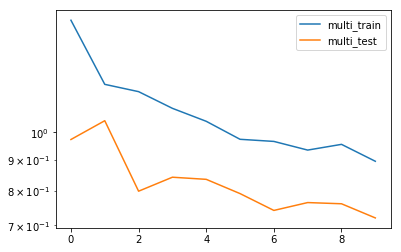

OI accuracy 0.4666666666666667
OI test_accuracy 0.6666666666666666
(4260, 15, 56) (4260,)
(4275,)
(4259, 15)
(4259, 15, 56) (4259, 15)
(4259, 15, 56) (4259, 15)


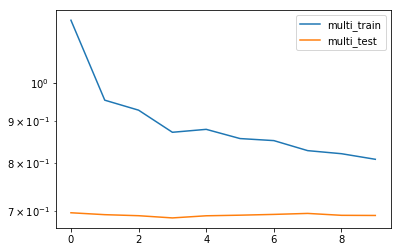

NI accuracy 0.6666666666666666
NI test_accuracy 0.26666666666666666
(4203, 15, 56) (4203,)
(4218,)
(4202, 15)
(4202, 15, 56) (4202, 15)
(4202, 15, 56) (4202, 15)


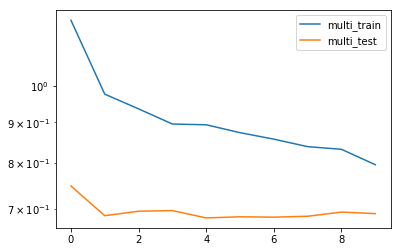

UPS accuracy 0.4666666666666667
UPS test_accuracy 0.3333333333333333
(4259, 15, 56) (4259,)
(4274,)
(4258, 15)
(4258, 15, 56) (4258, 15)
(4258, 15, 56) (4258, 15)


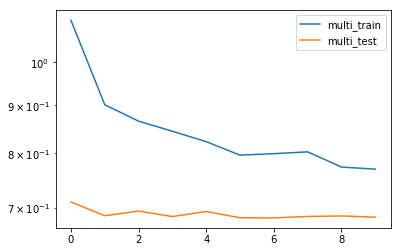

HSIC accuracy 0.6666666666666666
HSIC test_accuracy 0.5333333333333333
(4265, 15, 56) (4265,)
(4280,)
(4264, 15)
(4264, 15, 56) (4264, 15)
(4264, 15, 56) (4264, 15)


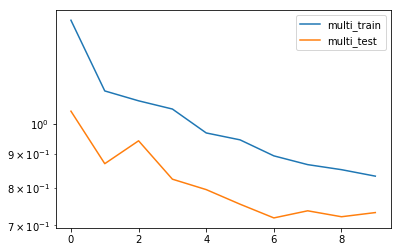

CCE accuracy 0.6
CCE test_accuracy 0.5333333333333333
(4260, 15, 56) (4260,)
(4275,)
(4259, 15)
(4259, 15, 56) (4259, 15)
(4259, 15, 56) (4259, 15)


In [ ]:
stocks=['OI','NI','UPS','HSIC','CCE','IBM','MAS','EFX','AAPL','WDC']
accuracy=pd.DataFrame()
test_accuracy=pd.DataFrame()
for Stock in stocks:
    scaled = data_prepare(Stock)
    scaled2, scaled, train_X, train_y, test_X, test_y = data_gen(scaled, 15)
    model = MODEL()
    model, history = train_model(model, train_X, train_y)
    plot_loss(history)
    model.save_weights(Stock+'timeseriesgen_classification.h5')
    model_accuracy = acc(model, scaled2)
    model_test_accuracy = test_acc(model, test_X, test_y)
    print(Stock+' accuracy', model_accuracy)
    print(Stock +' test_accuracy', model_test_accuracy)
    accuracy = accuracy.append(pd.DataFrame([[Stock, model_accuracy]]),ignore_index=True)
    test_accuracy = test_accuracy.append(pd.DataFrame([[Stock, model_test_accuracy]]),ignore_index=True)
accuracy.columns=['Stock','accuracy']
test_accuracy.columns=['Stock','test_accuracy']